<a href="https://colab.research.google.com/github/kudanzakalabo/seminar/blob/main/Pretrained_Model_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ResNet

In [ ]:
#事前学習したモデルが用意されたモジュール
# https://pytorch.org/vision/stable/models.html
from torchvision import models

In [ ]:
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
#時間の計測
import time
from datetime import timedelta

In [ ]:
start_time = time.time()

In [ ]:
delta = timedelta(seconds=time.time()-start_time)

#データセット

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
from torchvision import transforms

In [ ]:
#https://www.cs.toronto.edu/~kriz/cifar.html
from torchvision.datasets import CIFAR10

In [ ]:
transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.5),(0.5),(0.5)),#画像を正規化
                              ])

In [ ]:
cifar10_train = CIFAR10('./',train=True,download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [ ]:
trainloader = DataLoader(cifar10_train, batch_size=100)

In [ ]:
img, lbl = next(iter(trainloader))

In [ ]:
lbl[1]

tensor(9)

In [ ]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


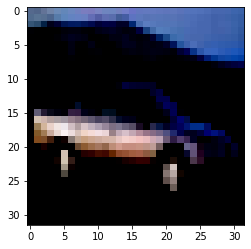

In [ ]:
plt.imshow(img[4].numpy().transpose(1,2,0))

In [ ]:
#出力の次元
model(img).shape

torch.Size([100, 1000])

In [ ]:
import numpy as np


In [ ]:
c = np.unique(np.array(cifar10_train.targets))
c

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
from torch import nn

In [ ]:
nn.Linear(in_features=2048, out_features=len(c), bias = True)

Linear(in_features=2048, out_features=10, bias=True)

In [ ]:
model = models.resnet50(pretrained=True)

In [ ]:
for name, param in model.named_parameters():
  if not name.startswith('fc'):
    param.requies_grad = False
  else:
    print(name)

fc.weight
fc.bias


In [ ]:
model.fc = nn.Linear(in_features=2048, out_features=len(c), bias = True)

In [ ]:
# Softmax を Sequential で追加 
sequential_resnet50 = nn.Sequential(model)

In [ ]:
sequential_resnet50.forward(img)[0]

tensor([ 0.0012,  0.6487, -0.2150, -0.4007,  0.2543,  0.1235, -0.8845, -0.2943,
         0.2187, -0.5245], grad_fn=<SelectBackward0>)

In [ ]:
from torch.optim import Adam, lr_scheduler

In [ ]:
optimizer = Adam(sequential_resnet50.parameters(), lr = 0.01)

In [ ]:
scheduler = lr_scheduler.LinearLR(optimizer)

In [ ]:
loss_func_BCE = nn.CrossEntropyLoss()

In [ ]:
#訓練モード・GPUにコピー
sequential_resnet50.train()
sequential_resnet50.cuda()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [ ]:
img, lbl = next(iter(trainloader))

In [ ]:
lbl[0], img[0].shape

(tensor(6), torch.Size([3, 32, 32]))

In [ ]:
loss_func_BCE(sequential_resnet50.forward(img.cuda()), lbl.cuda())

tensor(2.2646, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
#バッチの数
len(trainloader)

500

In [ ]:
%%time
loss_batch = []

for i, (batch, label) in zip(range(50), trainloader):
#for i, (batch, label) in enumerate(trainloader):

    loss = loss_func_BCE(sequential_resnet50.forward(batch.cuda()), label.cuda()) #順伝播

    optimizer.zero_grad() #勾配リセット

    loss.backward() #損失の逆伝播

    optimizer.step() #パラメタ更新

    loss_batch.append(loss.item()) #ログ


CPU times: user 3.58 s, sys: 106 ms, total: 3.69 s
Wall time: 3.89 s


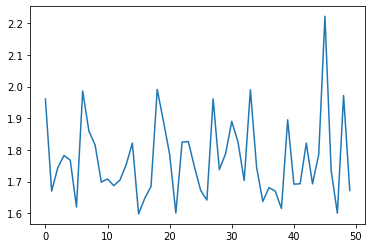

In [ ]:
plt.plot(loss_batch)

In [ ]:
%%time
max_epoch = 20 # 40 sec * 10 = 6m
loss_epoch = []

for i in range(max_epoch):
  start_time = time.time()

  loss_batch = []
  #for i, (batch, label) in zip(range(2), dataloader):
  for j, (batch, label) in enumerate(trainloader):
    loss = loss_func_BCE(sequential_resnet50.forward(batch.cuda()), label.cuda())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    loss_batch.append(loss.item())

  loss_epoch.append(sum(loss_batch))
  #print('Epoch:', i, loss_epoch[-1])
  delta = timedelta(seconds=time.time()-start_time)
  print('Epoch:',i, loss_epoch[-1], delta)


Epoch: 0 781.3661156892776 0:00:33.202999
Epoch: 1 648.2616037130356 0:00:33.304983
Epoch: 2 550.6373327374458 0:00:32.989774
Epoch: 3 457.2303603887558 0:00:33.440920
Epoch: 4 395.8691945075989 0:00:33.141835
Epoch: 5 349.068685233593 0:00:33.344566
Epoch: 6 314.37007465958595 0:00:33.028932
Epoch: 7 279.50559690594673 0:00:32.820459
Epoch: 8 252.52345216274261 0:00:32.996208
Epoch: 9 298.14777958393097 0:00:32.863284
Epoch: 10 230.54225236177444 0:00:32.797843
Epoch: 11 171.46161246299744 0:00:32.895323
Epoch: 12 151.41966025531292 0:00:32.798787
Epoch: 13 133.52767626196146 0:00:32.837774
Epoch: 14 117.8971088975668 0:00:32.973176
Epoch: 15 102.30538172647357 0:00:33.051789
Epoch: 16 90.80022339522839 0:00:33.091595
Epoch: 17 82.77266250178218 0:00:33.192598
Epoch: 18 125.1197667978704 0:00:33.147665
Epoch: 19 68.5234814658761 0:00:32.982363
CPU times: user 10min 31s, sys: 29.7 s, total: 11min 1s
Wall time: 11min


#Screw データセット (Box)

In [ ]:
from urllib import request

In [ ]:
boxurl='https://tus.box.com/shared/static/6307hz4gxye723bk5pkrugghegsepa4o.tgz'
filename='screw_test.tgz'

In [ ]:
request.urlretrieve(boxurl,filename)

('screw_test.tgz', <http.client.HTTPMessage at 0x7f92120b0450>)

In [ ]:
boxurl='https://tus.box.com/shared/static/mj6x66n9xdzdn4ei3cwk1b3varrt75yg.tgz'
filename='screw_train.tgz'

In [ ]:
request.urlretrieve(boxurl,filename)

('screw_train.tgz', <http.client.HTTPMessage at 0x7f921208ec10>)

In [ ]:
boxurl='https://tus.box.com/shared/static/ub800wxp8cvzllbbm7gd4hsez95baflz.tgz'
filename='screw_csv.tgz'

In [ ]:
request.urlretrieve(boxurl,filename)

('screw_csv.tgz', <http.client.HTTPMessage at 0x7f92120a3cd0>)

In [ ]:
! for name in *.tgz; do tar -xzf $name; done

#From Simple sample code

In [ ]:
resize_w = 256
resize_h = 256
channel = 3

import cv2
# 画像が大きいと計算が遅いため、リサイズ縮小
def resize(tmp_image):
    return cv2.resize(tmp_image , (resize_h, resize_w))

# 4次元配列化()　
def to_4d(tmp_image):
    return tmp_image.reshape(1, resize_h, resize_w, channel)
    

# 256段階の色調を0.0~1.0にする
def normalize(tmp_image):
    return tmp_image / 255.0

# 画像の前処理付きロード
def load_preprocessed_image(image_filepath):
    tmp_image = cv2.imread(image_filepath)
    tmp_image = resize(tmp_image)
    tmp_image = normalize(tmp_image)
    tmp_image = to_4d(tmp_image)
    return tmp_image

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [ ]:
root_path = '/content/kaggle/input/screw-dataset/'

train_csv_filepath = root_path + "train.csv"

# ファイルの読み込み
train_df = pd.read_csv(train_csv_filepath)

train_df

,filename,anomaly
0,manipulated_front000.png,1
1,manipulated_front001.png,1
2,manipulated_front002.png,1
3,manipulated_front003.png,1
4,manipulated_front004.png,1
...,...,...
295,thread_top005.png,1
296,thread_top006.png,1
297,thread_top007.png,1
298,thread_top008.png,1


In [ ]:
images = None

for fn in train_df['filename']:
    image_filepath = root_path + 'train/' + fn
    tmp_image = load_preprocessed_image(image_filepath)
    if (images is None):
        images = tmp_image
    else:
        images = np.vstack((images, tmp_image))

# 確認
images.shape

(300, 256, 256, 3)

In [ ]:
anomaly_flags = np.array([flag for flag in train_df['anomaly']]).astype(int)

anomaly_flags

# 確認
#anomaly_flags = np_utils.to_categorical(anomaly_flags, 2)
#anomaly_flags.shape


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

In [ ]:
class ScrewImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
from torch.nn import Conv2d, MaxPool2d
from torch.nn import ReLU, Dropout, Flatten, Linear, Softmax

from torch.optim import Adam
from torchvision import transforms, models

In [ ]:
models.vgg16()

In [ ]:

from keras.datasets import mnist
#kerasでCNN構築
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam

 
'''
CNNの構築
'''
 
model = Sequential()
 
model.add(Conv2D(filters=10, kernel_size=(4,4), padding='same', input_shape=(256, 256, 3), activation='relu'))
model.add(Conv2D(filters=10, kernel_size=(3,3), padding='same', input_shape=(64, 64, 8), activation='relu'))
model.add(Conv2D(filters=10, kernel_size=(2,2), padding='same', input_shape=(16, 16, 16), activation='relu'))

model.add(Flatten())
model.add(Dense(2, activation='softmax'))
 
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0003), metrics=['accuracy'])

